In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
import ast
import csv
import itertools
import random
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import Train
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [4]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [5]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [6]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 135
Validation set size: 34


In [7]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [8]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6], [8]],
    'hidden_activation': [Activation_Tanh, Activation_Leaky_ReLU, Activation_Sigmoid, Activation_ReLU],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-2, 1e-4, 1e-3, 2e-4,1e-6, 1e-5],
    'l1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [8, 16, 32],
    'n_epochs': [100, 150, 200, 250, 300],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-4, 1e-5],
    'patience': [0, 20, 30, 50],
    'CC': [False],
    'weights_init': ['gaussian', 'gaussian_scaled', 'xavier', 'he', 'random'],
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [9]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=50)  # adjust n_iters as needed

print(best_hyperparams)

[3] <class 'src.activation_functions.Activation_Tanh'> [0.0] [True]
Data shapes:
X_train: (108, 17), y_train: (108, 1)
Hyperparams: {'hidden_size': [3], 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': [True], 'learning_rate': 1e-05, 'l1': 1e-06, 'l2': 0.0001, 'dropout_rate': 0.0, 'batch_size': 32, 'n_epochs': 250, 'weight_decay': 0.0001, 'patience': 20, 'CC': False, 'weights_init': 'gaussian'}
Epoch 0: Train Loss: 0.2487, Acc: 57.03% | Val Loss: 0.2562, Acc: 48.15%
Epoch 10: Train Loss: 0.2504, Acc: 53.91% | Val Loss: 0.2458, Acc: 59.26%
Epoch 20: Train Loss: 0.2499, Acc: 56.25% | Val Loss: 0.2451, Acc: 59.26%
Epoch 30: Train Loss: 0.2563, Acc: 48.18% | Val Loss: 0.2454, Acc: 59.26%
Epoch 40: Train Loss: 0.2444, Acc: 61.46% | Val Loss: 0.2454, Acc: 59.26%
Early stopping at epoch 47
Restoring model weights from epoch 27
Final Validation score: 0.5926
✅ Fold 1/5 | Validation Accuracy: 0.5926
[3] <class 'src.activation_functions.Activation_Tanh'> [0.

In [10]:
print(best_hyperparams)

{'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Sigmoid'>, 'batch_norm': [False], 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-05, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 250, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'he', 'val_accuracy': np.float64(1.0)}


GRID SEARCH

[8] <class 'src.activation_functions.Activation_Sigmoid'> [0.3] [False]
Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Sigmoid'>, 'batch_norm': [False], 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-05, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 250, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'he', 'val_accuracy': np.float64(1.0)}
Epoch 0: Train Loss: 0.2994, Acc: 57.67% | Val Loss: 0.3212, Acc: 55.88%
Epoch 10: Train Loss: 0.2347, Acc: 65.13% | Val Loss: 0.2587, Acc: 55.88%
Epoch 20: Train Loss: 0.2041, Acc: 64.60% | Val Loss: 0.2353, Acc: 58.82%
Epoch 30: Train Loss: 0.1846, Acc: 69.54% | Val Loss: 0.2288, Acc: 61.76%
Epoch 40: Train Loss: 0.1549, Acc: 77.21% | Val Loss: 0.2000, Acc: 70.59%
Epoch 50: Train Loss: 0.1508, Acc: 71.22% | Val Loss: 0.1684, Acc: 79.41%
Epoch 60: Train Loss: 0.1240, Acc: 82.88% | Val Loss: 0.1303, Acc: 88.24%
Epoch 70: Train Loss

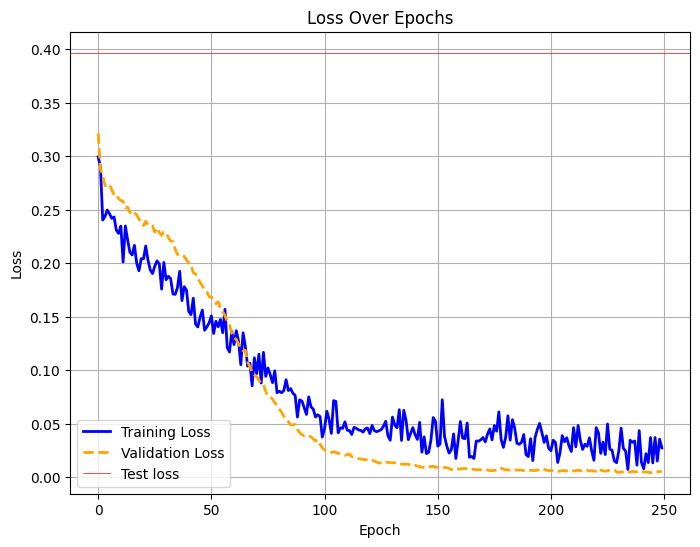

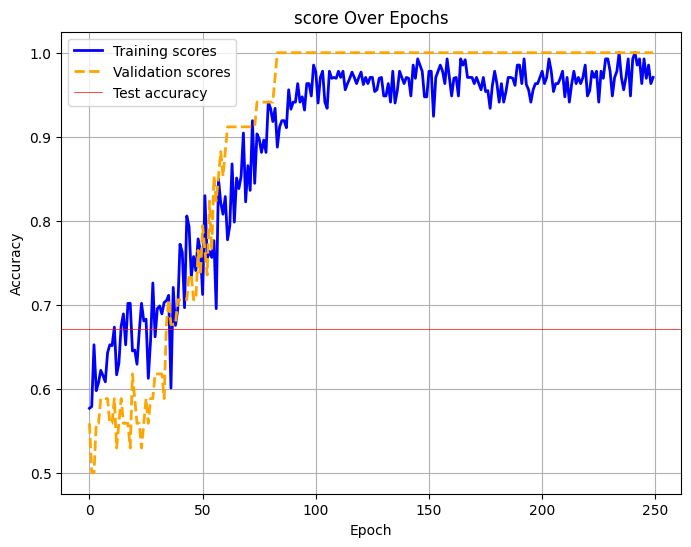

In [11]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_sizes=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rates=[best_hyperparams['dropout_rate']],
        use_batch_norm=best_hyperparams['batch_norm']
    )

train = Train(best_hyperparams, model)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_test, y_test)
train.plot(score=True)

In [12]:
print(train.train_losses, train.val_losses)

[np.float64(0.29942519338667306), np.float64(0.28974775935807384), np.float64(0.24043993484461942), np.float64(0.24374603420533134), np.float64(0.24978413006125025), np.float64(0.2461707648661203), np.float64(0.2419091871608877), np.float64(0.2432889647691044), np.float64(0.23099187914656613), np.float64(0.2279091491878127), np.float64(0.23472072952837295), np.float64(0.20111960122541794), np.float64(0.2348924388237498), np.float64(0.22184090963195688), np.float64(0.21028674383833665), np.float64(0.20781007529436013), np.float64(0.21674064253110428), np.float64(0.2000122819696696), np.float64(0.19297736972388224), np.float64(0.2042747451466816), np.float64(0.20412331384035287), np.float64(0.21609587603823754), np.float64(0.2027363046559377), np.float64(0.19377244136433747), np.float64(0.19035442266189045), np.float64(0.19735162610142676), np.float64(0.20218979248891875), np.float64(0.19920443743274543), np.float64(0.17585574766419831), np.float64(0.20078413303172202), np.float64(0.1845

In [13]:
print(f"Test Accuracy: {train.test_score:.4f}")

Test Accuracy: 0.6713


In [14]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_sizes=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hyperparams['hidden_activation'],
                dropout_rates=[hyperparams['dropout_rate']],
                use_batch_norm=hyperparams['batch_norm']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

[8] <class 'src.activation_functions.Activation_Sigmoid'> [0.3] [False]
Training model 1/5
Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'hidden_size': [8], 'hidden_activation': <class 'src.activation_functions.Activation_Sigmoid'>, 'batch_norm': [False], 'learning_rate': 0.01, 'l1': 1e-05, 'l2': 1e-05, 'dropout_rate': 0.3, 'batch_size': 8, 'n_epochs': 250, 'weight_decay': 0, 'patience': 50, 'CC': False, 'weights_init': 'he', 'val_accuracy': np.float64(1.0)}
Epoch 0: Train Loss: 0.3115, Acc: 48.84% | Val Loss: 0.2759, Acc: 58.82%
Epoch 10: Train Loss: 0.2361, Acc: 59.77% | Val Loss: 0.2426, Acc: 61.76%
Epoch 20: Train Loss: 0.2052, Acc: 67.65% | Val Loss: 0.2424, Acc: 58.82%
Epoch 30: Train Loss: 0.2088, Acc: 65.02% | Val Loss: 0.2340, Acc: 61.76%
Epoch 40: Train Loss: 0.1999, Acc: 69.54% | Val Loss: 0.2327, Acc: 58.82%
Epoch 50: Train Loss: 0.1898, Acc: 71.11% | Val Loss: 0.2139, Acc: 64.71%
Epoch 60: Train Loss: 0.1739, Acc: 73.42% | Val Loss: 0.1954, Acc: 67.65%
E

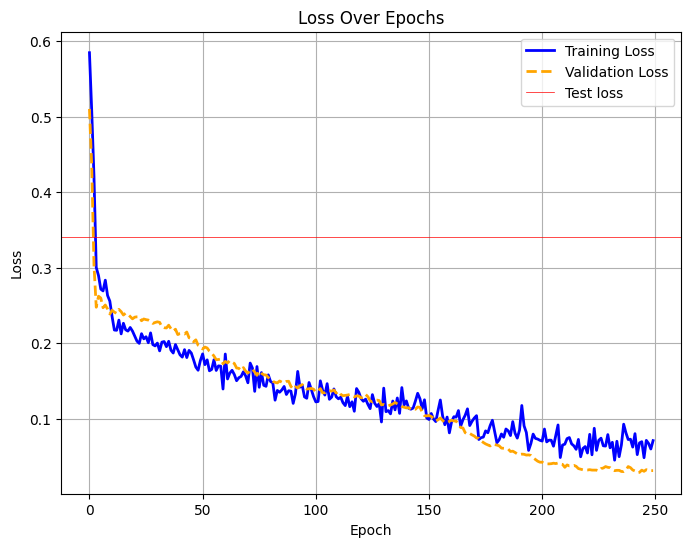

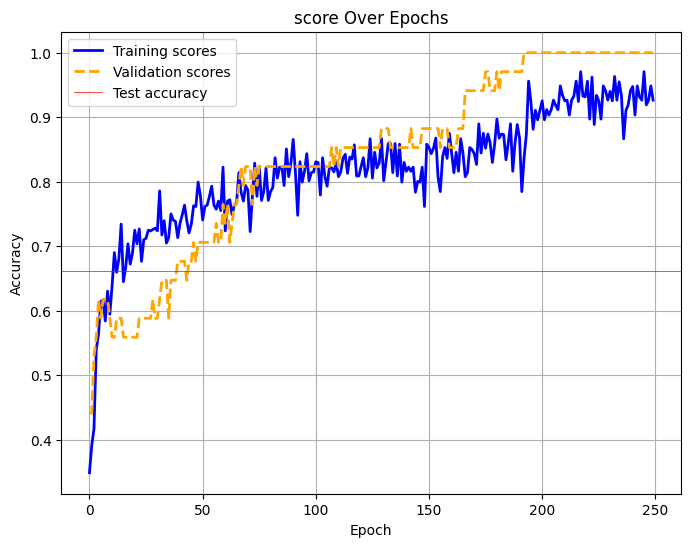

In [15]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(score=True)